# Hubble Source Catalog API Notebook
### August 2019, Rick White

A [new MAST interface](https://catalogs.mast.stsci.edu/hsc) supports queries to the current and previous versions of the [Hubble Source Catalog](https://archive.stsci.edu/hst/hsc). It allows searches of the summary table (with multi-filter mean photometry) and the detailed table (with all the multi-epoch measurements).  It also has an associated [API](https://catalogs.mast.stsci.edu/docs/hsc.html), which is used in this notebook.

This is based on [HSC Use Case #3](https://archive.stsci.edu/hst/hsc/help/use_case_3_v2.html).
* It searches the HSC for variable objects in the vicinity of dwarf galaxy IC 1613,
* shows the positions of those objects in a color-magnitude diagram,
* extracts light curves for an example object, and
* displays cutout images from the Hubble observations that were used for the light curve measurements.

The whole process takes only 30 seconds to complete.

This notebook is available for [download](hscv3_api.ipynb).  Another [simple notebook](hscv3_smc_api.html) generates a color-magnitude diagram for the Small Magellanic Cloud in only a couple of minutes.  A more complex notebook that shows how to access the proper motion tables using the HSC API is also [available](sweeps_hscv3p1_api.html).

# Instructions: 
* Complete the initialization steps [described below](#Initialization).
* Run the notebook.

Running the notebook from top to bottom takes about 30 seconds.


# Table of Contents
* [Initialization](#Initialization)
* [Get metadata on available HSC columns](#metadata)
* [Find variable objects in IC 1613](#ic1613)
    * [Use MAST name resolver](#resolver)
    * [Search HSC summary table](#summary)
    * [Plot variability index versus magnitude](#variability)
    * [Show variable objects in a color-magnitude diagram](#cmd)
* [Get HSC light curve for a variable](#lightcurve)
* [Extract HLA cutout images for the variable](#cutouts)

# Initialization <a class="anchor" id="Initialization"></a>

### Install Python modules

_This notebook requires the use of **Python 3**._

This needs the `requests` and `pillow` modules in addition to the common requirements of `astropy`, `numpy` and `scipy`.  For anaconda versions of Python the installation commands are:

<pre>
conda install requests
conda install pillow
</pre>

In [2]:
%matplotlib inline
import astropy, pylab, time, sys, os, requests, json
import numpy as np
from pprint import pprint

from astropy.table import Table
import pandas as pd

from PIL import Image
from io import BytesIO, StringIO

# Set page width to fill browser for longer output lines
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# set width for pprint
astropy.conf.max_width = 150

## Useful functions

Execute HSC searches and resolve names using [MAST query](https://mast.stsci.edu/api/v0/MastApiTutorial.html).

In [3]:
hscapiurl = "https://catalogs.mast.stsci.edu/api/v0.1/hsc"

def hsccone(ra,dec,radius,table="summary",release="v3",format="csv",magtype="magaper2",
            columns=None, baseurl=hscapiurl, verbose=False,
            **kw):
    """Do a cone search of the HSC catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json, table
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return hscsearch(table=table,release=release,format=format,magtype=magtype,
                     columns=columns,baseurl=baseurl,verbose=verbose,**data)


def hscsearch(table="summary",release="v3",magtype="magaper2",format="csv",
              columns=None, baseurl=hscapiurl, verbose=False,
              **kw):
    """Do a general search of the HSC catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json, table
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    if format not in ("csv","votable","json","table"):
        raise ValueError("Bad value for format")
    if format == "table":
        rformat = "csv"
    else:
        rformat = format
    url = "{}.{}".format(cat2url(table,release,magtype,baseurl=baseurl),rformat)
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in hscmetadata(table,release,magtype)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

    # either get or post works
    # r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    elif format == "table":
        # use pandas to work around bug in Windows for ascii.read
        return Table.from_pandas(pd.read_csv(StringIO(r.text)))
    else:
        return r.text


def hscmetadata(table="summary",release="v3",magtype="magaper2",baseurl=hscapiurl):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    url = "{}/metadata".format(cat2url(table,release,magtype,baseurl=baseurl))
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab


def cat2url(table="summary",release="v3",magtype="magaper2",baseurl=hscapiurl):
    """Return URL for the specified catalog and table
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns a string with the base URL for this request
    """
    checklegal(table,release,magtype)
    if table == "summary":
        url = "{baseurl}/{release}/{table}/{magtype}".format(**locals())
    else:
        url = "{baseurl}/{release}/{table}".format(**locals())
    return url


def checklegal(table,release,magtype):
    """Checks if this combination of table, release and magtype is acceptable
    
    Raises a ValueError exception if there is problem
    """
    
    releaselist = ("v2", "v3")
    if release not in releaselist:
        raise ValueError("Bad value for release (must be one of {})".format(
            ', '.join(releaselist)))
    if release=="v2":
        tablelist = ("summary", "detailed")
    else:
        tablelist = ("summary", "detailed", "propermotions", "sourcepositions")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(
            release, ", ".join(tablelist)))
    if table == "summary":
        magtypelist = ("magaper2", "magauto")
        if magtype not in magtypelist:
            raise ValueError("Bad value for magtype (must be one of {})".format(
                ", ".join(magtypelist)))


def mastQuery(request, url='https://mast.stsci.edu/api/v0/invoke'):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    url (string): The service URL

    Returns the returned data content
    """
    
    # Encoding the request as a json string
    requestString = json.dumps(request)
    r = requests.post(url, data={'request': requestString})
    r.raise_for_status()
    return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position
    """

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObjectString = mastQuery(resolverRequest)
    resolvedObject = json.loads(resolvedObjectString)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

## Get metadata on available columns <a name="metadata"></a>

The `metadata` query returns information on the columns in the table.  It works for any of the tables in the API (`summary`, `detailed`, `propermotions`, `sourcepositions`).

Note that the summary table has a huge number of columns!  Each of the 133 filter/detector combinations has 3 columns with the magnitude, median absolute deviation (MAD, a robust measure of the scatter among the measurements), and the number of independent measurements in the filter.  The filter name includes a prefix for the detector (`A`=ACS/WFC, `W3`=WFC3/UVIS or WFC3/IR, `W2`=WFPC2) followed by the standard name of the filter.  So for instance all three instruments have an F814W filter, so there are columns for `A_F814W`, `W3_F814W`, and `W2_F814W`.

In [4]:
meta = hscmetadata("summary")
print(len(meta),"columns in summary")
filterlist = meta['name'][19::3].tolist()
print(len(filterlist),"filters")
pprint(filterlist, compact=True)
meta[:19]

418 columns in summary
133 filters
['W3_BLANK', 'W2_F122M', 'W2_F160BN15', 'W2_F160BW', 'W2_F170W', 'W2_F185W',
 'W3_F200LP', 'W3_F218W', 'W2_F218W', 'W3_F225W', 'W3_FQ232N', 'W3_FQ243N',
 'W2_F255W', 'W3_F275W', 'W3_F280N', 'W3_G280', 'W2_F300W', 'W3_F300X',
 'W3_F336W', 'W2_F336W', 'W3_F343N', 'W2_F343N', 'W3_F350LP', 'W3_F373N',
 'W2_F375N', 'W3_FQ378N', 'W2_F380W', 'W3_FQ387N', 'W3_F390M', 'W2_F390N',
 'W3_F390W', 'W3_F395N', 'W3_F410M', 'W2_F410M', 'W3_FQ422M', 'A_F435W',
 'W3_FQ436N', 'W3_FQ437N', 'W2_F437N', 'W3_F438W', 'W2_F439W', 'W2_F450W',
 'W3_F467M', 'W2_F467M', 'W3_F469N', 'W2_F469N', 'A_F475W', 'W3_F475W',
 'W3_F475X', 'W3_F487N', 'W2_F487N', 'W3_FQ492N', 'A_F502N', 'W3_F502N',
 'W2_F502N', 'W3_FQ508N', 'W3_F547M', 'W2_F547M', 'A_F550M', 'A_F555W',
 'W3_F555W', 'W2_F555W', 'W2_F569W', 'W3_FQ575N', 'W2_F588N', 'W3_F600LP',
 'A_F606W', 'W3_F606W', 'W2_F606W', 'W3_FQ619N', 'W3_F621M', 'W2_F622W',
 'A_F625W', 'W3_F625W', 'W3_F631N', 'W2_F631N', 'W3_FQ634N', 'W3_F645N',
 'W3_

name,type,description
str16,str5,str163
MatchID,long,identifier for the match
MatchRA,float,right ascension coordinate of the match position
MatchDec,float,declination coordinate of the match position
DSigma,float,standard deviation of source positions in match
AbsCorr,char,indicator of whether the match contains sources that are aligned to a standard catalog
NumFilters,int,number of filters in match with sources detected in the aper2 aperture
...,...,...
TargetName,char,name of a target for an exposure in match
CI,float,average normalized concentration index for sources detected in the aper2 aperture within the match


## Find variable objects in the dwarf irregular galaxy IC 1613 <a name="ic1613"></a>

This is based on [HSC Use Case #3](https://archive.stsci.edu/hst/hsc/help/use_case_3_v2.html), which shows an example of selecting objects from the HSC in portal.  This is simple to do using the HSC API.

### Use MAST name resolver to get position of IC 1613 <a name="resolver"></a>

In [5]:
target = 'IC 1613'
ra, dec = resolve(target)
print(target,ra,dec)

IC 1613 16.2258 2.1333


### Select objects with enough measurements to determine variability <a name="summary"></a>

This searches the summary table for objects within 0.5 degrees of the galaxy center that have at least 10 measurements in both ACS F475W and F814W.

In [6]:
# save typing a quoted list of columns
columns = """MatchID,MatchRA,MatchDec,NumFilters,NumVisits,NumImages,StartMJD,StopMJD,
    A_F475W, A_F475W_N, A_F475W_MAD,
    A_F814W, A_F814W_N, A_F814W_MAD""".split(",")
columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]

constraints = {'A_F475W_N.gte': 10, 'A_F814W_N.gte': 10}

t0 = time.time()
tab = hsccone(ra,dec,0.5,table="summary",release='v3',columns=columns,verbose=True,
              format="table", **constraints)
print("{:.1f} s: retrieved data and converted to {}-row astropy table".format(time.time()-t0, len(tab)))

# clean up the output format
tab['A_F475W'].format = "{:.3f}"
tab['A_F475W_MAD'].format = "{:.3f}"
tab['A_F814W'].format = "{:.3f}"
tab['A_F814W_MAD'].format = "{:.3f}"
tab['MatchRA'].format = "{:.6f}"
tab['MatchDec'].format = "{:.6f}"
tab['StartMJD'].format = "{:.5f}"
tab['StopMJD'].format = "{:.5f}"
tab

https://catalogs.mast.stsci.edu/api/v0.1/hsc/v3/summary/magaper2.csv?A_F475W_N.gte=10&A_F814W_N.gte=10&ra=16.2258&dec=2.1333&radius=0.5&columns=%5BMatchID%2CMatchRA%2CMatchDec%2CNumFilters%2CNumVisits%2CNumImages%2CStartMJD%2CStopMJD%2CA_F475W%2CA_F475W_N%2CA_F475W_MAD%2CA_F814W%2CA_F814W_N%2CA_F814W_MAD%5D
14.8 s: retrieved data and converted to 18666-row astropy table


MatchID,MatchRA,MatchDec,NumFilters,NumVisits,NumImages,StartMJD,StopMJD,A_F475W,A_F475W_N,A_F475W_MAD,A_F814W,A_F814W_N,A_F814W_MAD
int64,float64,float64,int64,int64,int64,float64,float64,float64,int64,float64,float64,int64,float64
17923455,16.123442,2.169234,3,14,26,53965.29153,57009.86262,25.515,12,0.017,24.849,12,0.020
18175560,16.095864,2.149292,2,12,24,53965.29153,53967.71941,25.709,12,0.025,26.263,12,0.035
12935889,16.130944,2.170585,2,12,24,53965.29153,53967.71941,25.897,12,0.050,26.293,12,0.035
12945594,16.140148,2.151688,3,14,26,53965.29153,57009.86262,25.328,12,0.015,24.704,12,0.021
12951985,16.132547,2.178740,2,12,24,53965.29153,53967.71941,26.007,12,0.026,26.416,12,0.047
12955330,16.106790,2.182867,3,14,26,53965.29153,57009.86262,24.444,12,0.007,23.450,12,0.011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66980564,16.125611,2.135287,3,14,26,53965.29153,57009.86262,22.732,12,0.194,22.365,12,0.138
94990453,16.130919,2.144020,3,14,26,53965.29153,57009.86262,25.588,12,0.024,25.050,12,0.019


### Plot object positions on the sky

We mark the galaxy center as well.  Note that this field is in the outskirts of IC 1613.  The 0.5 search radius (which is the maximum allowed in the API) allows finding these objects.

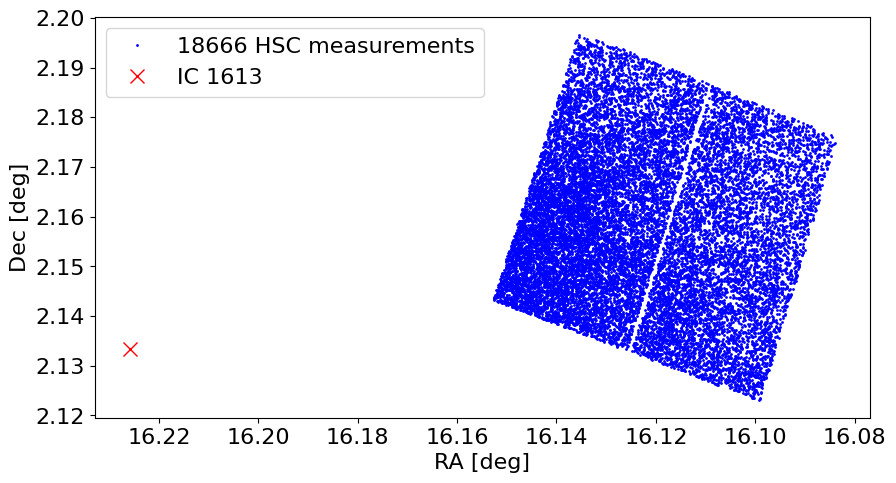

In [7]:
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,10))
pylab.plot(tab['MatchRA'], tab['MatchDec'], 'bo', markersize=1,
          label='{} HSC measurements'.format(len(tab)))
pylab.plot(ra,dec,'rx',label=target,markersize=10)
pylab.gca().invert_xaxis()
pylab.gca().set_aspect('equal')
pylab.xlabel('RA [deg]')
pylab.ylabel('Dec [deg]')
pylab.legend(loc='best')

### Plot MAD variability index versus magnitude in F475W <a name="variability"></a>

The median absolute deviation is measured among the ~12 magnitude measurements in the catalog.  Some scatter is expected from noise (which increases for fainter objects).   Objects with MAD values that are high are likely to be variable.

Select variable objects that are not too faint.

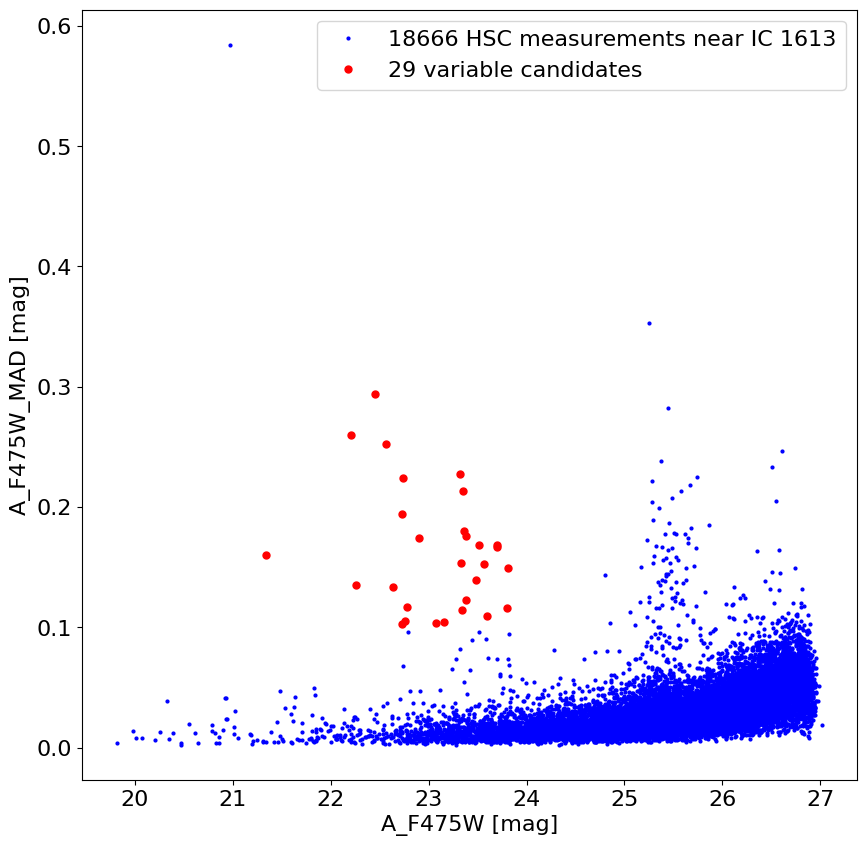

In [8]:
wvar = np.where((tab['A_F475W_MAD']>0.1) & (tab['A_F475W']<24) & (tab['A_F475W']>21))[0]
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,10))
pylab.plot(tab['A_F475W'], tab['A_F475W_MAD'], 'bo', markersize=2,
          label='{} HSC measurements near {}'.format(len(tab),target))
pylab.plot(tab['A_F475W'][wvar], tab['A_F475W_MAD'][wvar], 'ro', markersize=5,
          label='{} variable candidates'.format(len(wvar)))
pylab.xlabel('A_F475W [mag]')
pylab.ylabel('A_F475W_MAD [mag]')
pylab.legend(loc='best')

### Check positions of variable objects in a color-magnitude diagram <a name="cmd"></a>

Note that these objects are generally located in the Cepheid instability strip.

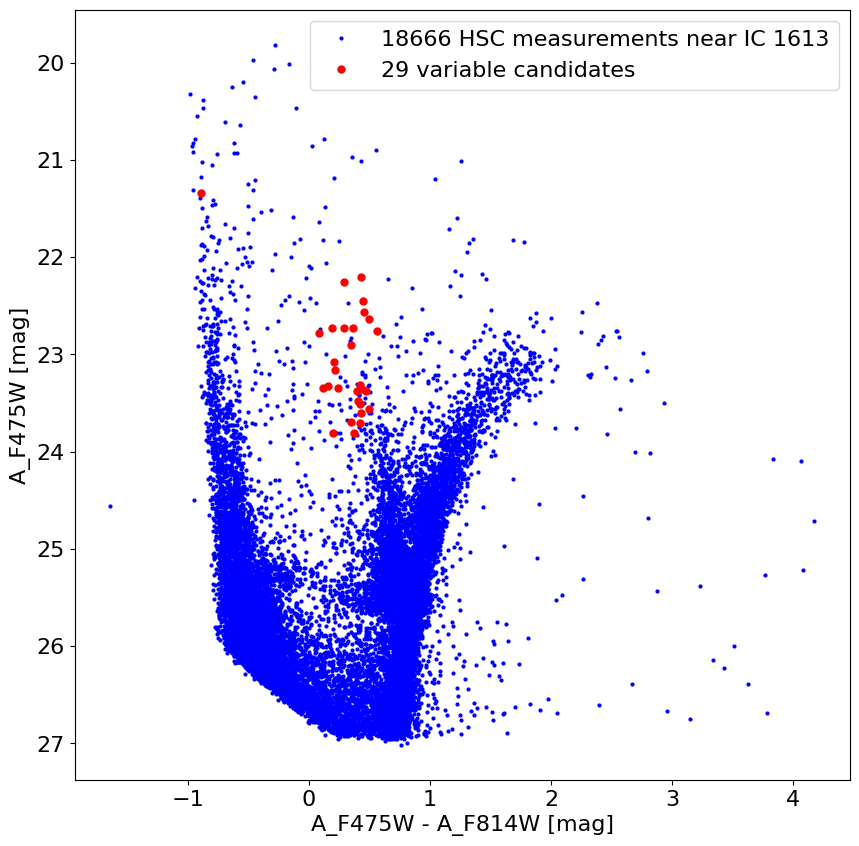

In [10]:
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,10))
b_minus_i = tab['A_F475W'] - tab['A_F814W']
pylab.plot(b_minus_i, tab['A_F475W'], 'bo', markersize=2,
          label='{} HSC measurements near {}'.format(len(tab),target))
pylab.plot(b_minus_i[wvar], tab['A_F475W'][wvar], 'ro', markersize=5,
          label='{} variable candidates'.format(len(wvar)))
pylab.ylabel('A_F475W [mag]')
pylab.xlabel('A_F475W - A_F814W [mag]')
pylab.gca().invert_yaxis()
pylab.legend(loc='best')

### Query the API for the light curve for one of the objects <a name="lightcurve"></a>

Select the most variable object as an example. 

In [11]:
wvar = wvar[np.argsort(-tab['A_F475W_MAD'][wvar])]
iselect = wvar[0]
print("MatchID {} B = {:.3f} B-I = {:.3f}".format(
    tab['MatchID'][iselect], tab['A_F475W'][iselect], b_minus_i[iselect]))
tab[wvar]

MatchID 80189155 B = 22.451 B-I = 0.450


MatchID,MatchRA,MatchDec,NumFilters,NumVisits,NumImages,StartMJD,StopMJD,A_F475W,A_F475W_N,A_F475W_MAD,A_F814W,A_F814W_N,A_F814W_MAD
int64,float64,float64,int64,int64,int64,float64,float64,float64,int64,float64,float64,int64,float64
80189155,16.140740,2.155288,3,14,26,53965.29153,57009.86262,22.451,12,0.294,22.001,12,0.198
8200488,16.144772,2.152338,3,14,26,53965.29153,57009.86262,22.202,12,0.260,21.768,12,0.188
66012678,16.135134,2.154740,3,14,26,53965.29153,57009.86262,22.559,12,0.253,22.101,12,0.192
63078526,16.105513,2.155580,3,14,26,53965.29153,57009.86262,23.317,12,0.227,22.897,12,0.138
89909862,16.117180,2.168810,3,14,26,53965.29153,57009.86262,22.733,12,0.224,22.545,12,0.099
92119358,16.136563,2.182817,2,12,24,53965.29153,53967.71941,23.347,12,0.213,23.234,12,0.131
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70217468,16.107142,2.178161,3,14,26,53965.29153,57009.86262,23.804,12,0.116,23.428,12,0.116
9510698,16.137963,2.141027,3,14,26,53965.29153,57009.86262,23.343,12,0.114,23.101,12,0.080


Get column metadata for detailed observation table (which has time-dependent magnitudes).

In [12]:
meta = hscmetadata("detailed")
print(len(meta),"columns in detailed")
pprint(meta['name'].tolist(), compact=True)

39 columns in detailed
['CatID', 'MatchID', 'MemID', 'SourceID', 'ImageID', 'Det', 'MatchRA',
 'MatchDec', 'SourceRA', 'SourceDec', 'D', 'DSigma', 'AbsCorr', 'XImage',
 'YImage', 'ImageName', 'Instrument', 'Mode', 'Detector', 'Aperture',
 'ExposureTime', 'StartTime', 'StopTime', 'StartMJD', 'StopMJD', 'WaveLength',
 'Filter', 'TargetName', 'FluxAper2', 'MagAper2', 'MagAuto', 'PropID', 'CI',
 'KronRadius', 'Flags', 'HTMID', 'X', 'Y', 'Z']


### Get separate light curves for F475W and F814W from the detailed table

In [13]:
columns = """MatchID,SourceID,StartMJD,Detector,Filter,MagAper2,Flags,ImageName""".split(",")
columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]

constraints = {'MatchID': tab['MatchID'][iselect], 'Detector': 'ACS/WFC'}
t0 = time.time()
f475 = hscsearch(table="detailed",release='v3',columns=columns,Filter='F475W',
                 format="table", **constraints)
f814 = hscsearch(table="detailed",release='v3',columns=columns,Filter='F814W',
                 format="table", **constraints)
print("{:.1f} s: retrieved data and converted to {} (F475W) and {} (F814W) row astropy tables".format(time.time()-t0, len(f475), len(f814)))

f475.sort('StartMJD')
f814.sort('StartMJD')
f475['MagAper2'].format = "{:.3f}"
f475['StartMJD'].format = "{:.5f}"
f814['MagAper2'].format = "{:.3f}"
f814['StartMJD'].format = "{:.5f}"

f475

4.0 s: retrieved data and converted to 12 (F475W) and 12 (F814W) row astropy tables


MatchID,SourceID,StartMJD,Detector,Filter,MagAper2,Flags,ImageName
int64,int64,float64,str7,str5,float64,int64,str26
80189155,4000999062305,53965.29153,ACS/WFC,F475W,22.192,0,hst_10505_07_acs_wfc_f475w
80189155,4000992888001,53965.42473,ACS/WFC,F475W,22.246,0,hst_10505_08_acs_wfc_f475w
80189155,4001095116962,53965.55794,ACS/WFC,F475W,22.376,0,hst_10505_09_acs_wfc_f475w
80189155,4000922680735,53965.69115,ACS/WFC,F475W,22.552,0,hst_10505_10_acs_wfc_f475w
80189155,4001042276145,53966.29057,ACS/WFC,F475W,22.705,0,hst_10505_11_acs_wfc_f475w
80189155,4001225221390,53966.42377,ACS/WFC,F475W,22.802,0,hst_10505_12_acs_wfc_f475w
80189155,4000895760719,53966.55698,ACS/WFC,F475W,22.779,0,hst_10505_13_acs_wfc_f475w
80189155,4000814317863,53966.69019,ACS/WFC,F475W,22.801,0,hst_10505_14_acs_wfc_f475w
80189155,4000830929643,53967.22301,ACS/WFC,F475W,22.526,0,hst_10505_15_acs_wfc_f475w


### Plot the light curves

The light curves appear well-behaved and are closely correlated in the two filters.

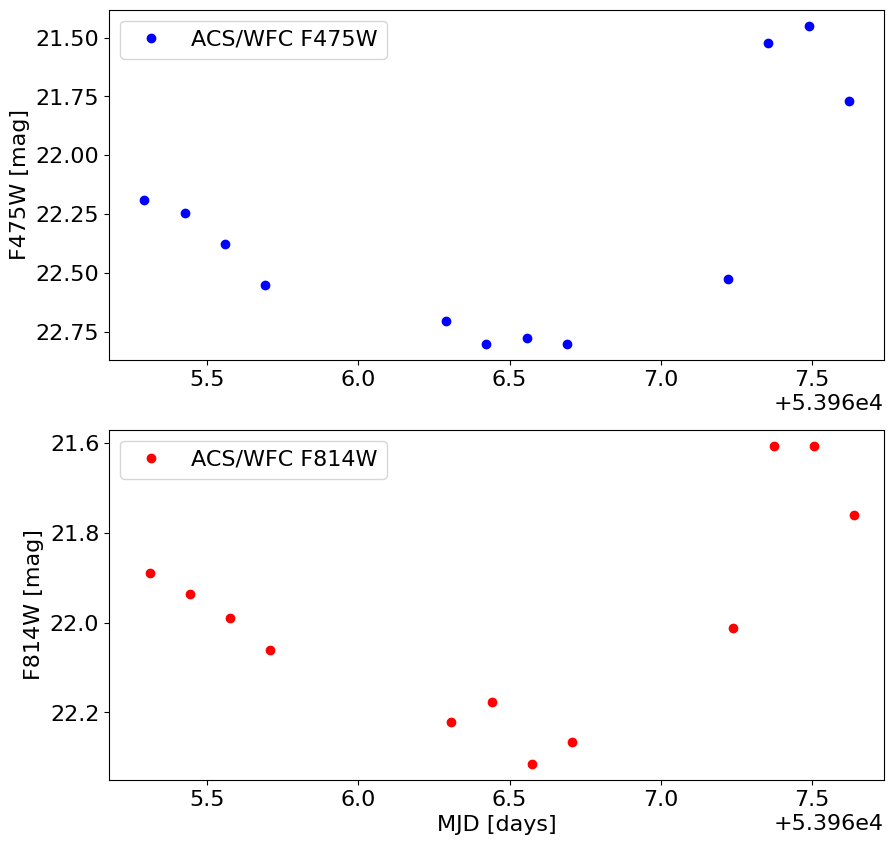

In [14]:
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,10))
pylab.subplot(211)
pylab.plot(f475['StartMJD'], f475['MagAper2'], 'bo', label='ACS/WFC F475W')
pylab.gca().invert_yaxis()
pylab.ylabel('F475W [mag]')
pylab.legend(loc='best')
xlim = pylab.xlim()

pylab.subplot(212)
pylab.plot(f814['StartMJD'], f814['MagAper2'], 'ro', label='ACS/WFC F814W')
pylab.gca().invert_yaxis()
pylab.ylabel('F814W [mag]')
pylab.xlabel('MJD [days]')
pylab.xlim(xlim)
pylab.legend(loc='best')

### Extract HLA cutout images for the F475W images <a name="cutouts"></a>

Get HLA F475W cutout images for the example variable.  The `get_hla_cutout` function reads a single cutout image (as a JPEG grayscale image) and returns a PIL image object.  See the documentation on the [fitscut image cutout service](http://hla.stsci.edu/fitscutcgi_interface.html) for more information on the web service being used.

Examination of the images can be useful to identified cosmic-ray contamination and other possible image artifacts.  In this case, no issues are seen, so the light curve is likely to be reliable.

20.9 s: finished 10 of 12
25.0 s: finished 12


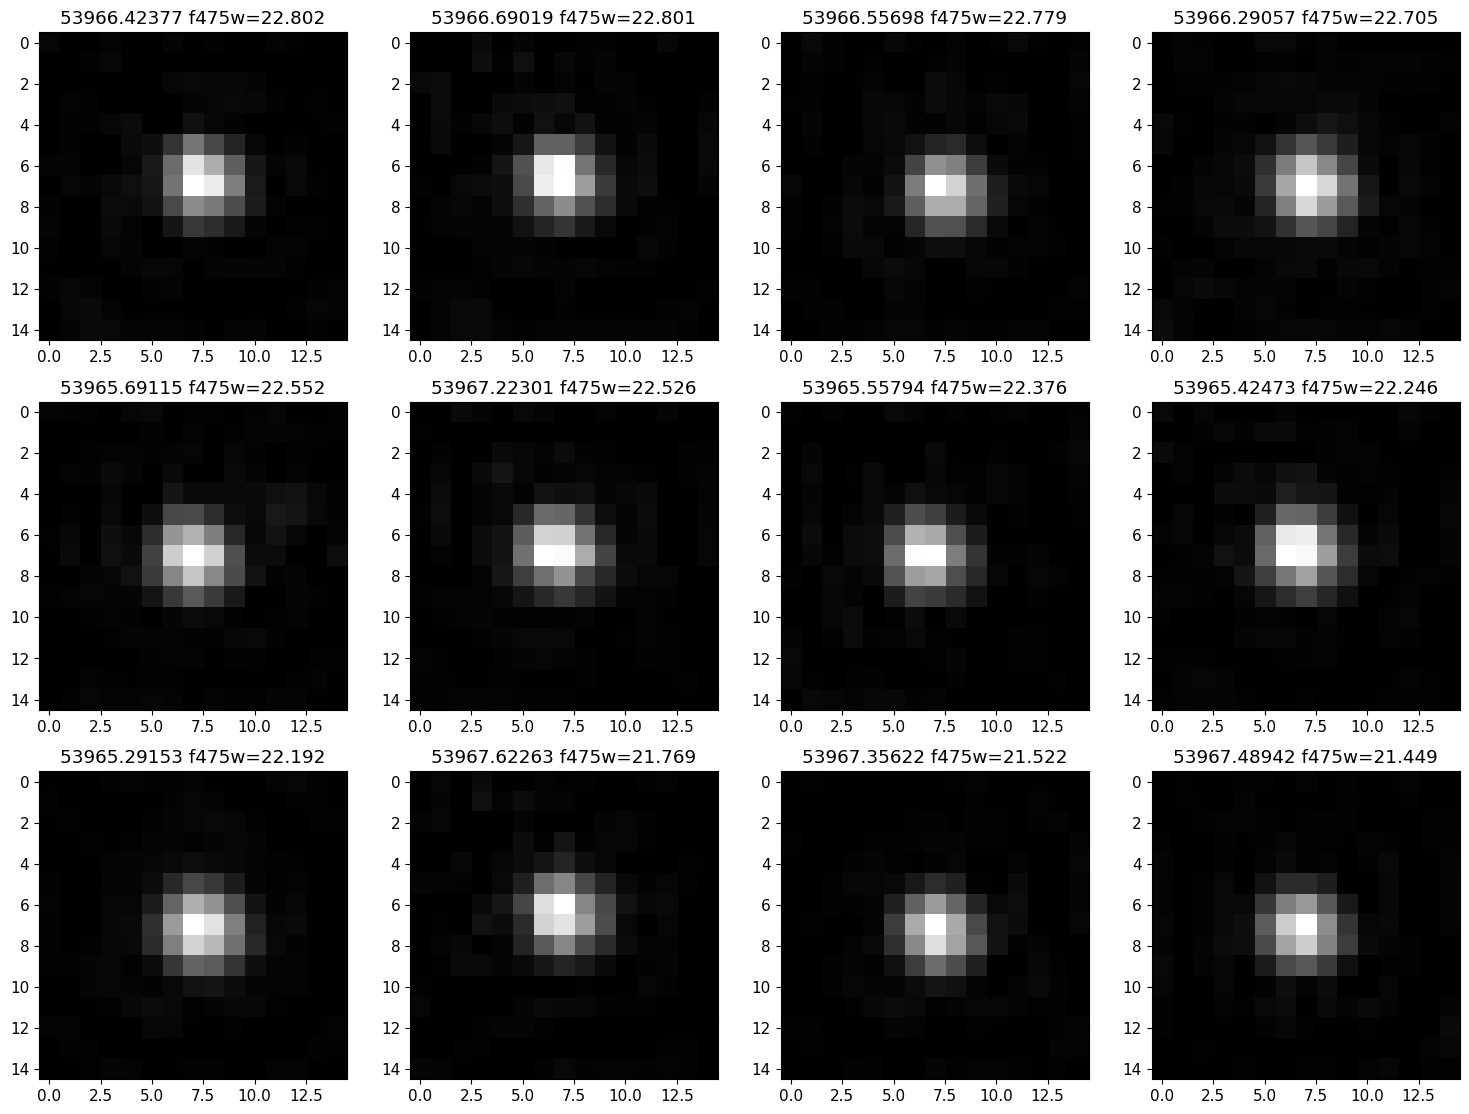

In [15]:
def get_hla_cutout(imagename,ra,dec,size=33,autoscale=99.5,asinh=1,zoom=1):
    
    """Get JPEG cutout for an image"""
    
    url = "https://hla.stsci.edu/cgi-bin/fitscut.cgi"
    r = requests.get(url, params=dict(ra=ra, dec=dec, size=size, 
            format="jpeg", red=imagename, autoscale=autoscale, asinh=asinh, zoom=zoom))
    im = Image.open(BytesIO(r.content))
    return im

# sort images by magnitude from faintest to brightest
isort = np.argsort(-f475['MagAper2'])

imagename = f475['ImageName'][isort]
mag = f475['MagAper2'][isort]
mjd = f475['StartMJD'][isort]

nim = len(imagename)
ncols = 4 # images per row
nrows = (nim+ncols-1)//ncols

imsize = 15
mra = tab['MatchRA'][iselect]
mdec = tab['MatchDec'][iselect]

pylab.rcParams.update({"font.size":11})
pylab.figure(1,(15, (15/ncols)*nrows))
t0 = time.time()
for k in range(nim):
    im1 = get_hla_cutout(imagename[k],mra,mdec,size=imsize)
    pylab.subplot(nrows,ncols,k+1)
    pylab.imshow(im1,origin="upper",cmap="gray")
    pylab.title('{:.5f} f475w={:.3f}'.format(mjd[k],mag[k]))
    if ((k+1) % 10)==0:
        print("{:.1f} s: finished {} of {}".format(time.time()-t0,k+1,nim))
pylab.tight_layout()
print("{:.1f} s: finished {}".format(time.time()-t0,nim))